# Graph and geometric learning

In this notebook your task is to prepare data for geometric learning. First we will look at converting images to graphs. Then we will look at getting graphs from 3D data. Lastly we will train GCN to classify the 3D objects

# MNIST super pixels

Firstly let us make graphs from images

In [76]:
import tensorflow as tf
import numpy as np
#%matplotlib inline
import matplotlib.pyplot as plt
from skimage import color, segmentation
from skimage.segmentation import mark_boundaries
from skimage.segmentation import slic
from skimage.measure import regionprops
from skimage import graph
import networkx as nx
from tensorflow import keras
from keras import layers

In [101]:
print(tf.__version__) # check we are using tensorflow v1.15 as this is required for GCN

2.16.2


In [78]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() #Load the mnist dataset

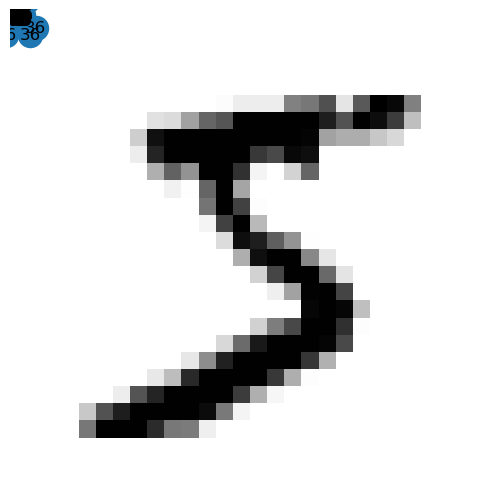

In [79]:
#get first image data and label and plot it
plt.imshow(x_train[0,:,:], cmap='gray_r')
plt.show()

In [80]:
# write a function that preprocesses an input image to have 3 channels in the output. This is required for the segmentation. 
def _preprocess(image): #make image have 3 channels
    if len(image.shape) == 2 or image.shape[2] == 1:
        return color.gray2rgb(
            np.reshape(image, (image.shape[0], image.shape[1])))
    else:
        return image

In [81]:
# write a function that takes the image, preprocesses it using the previous function we wrote and then uses the slic function to obtain the segmentation. It requires the number of segments and compactnesss to be set
def get_slic(image, n_segments, compactness):
  processed_image = _preprocess(image) #process image
  output =  slic(processed_image, n_segments=n_segments, compactness=compactness)#get segmentation 
  return output

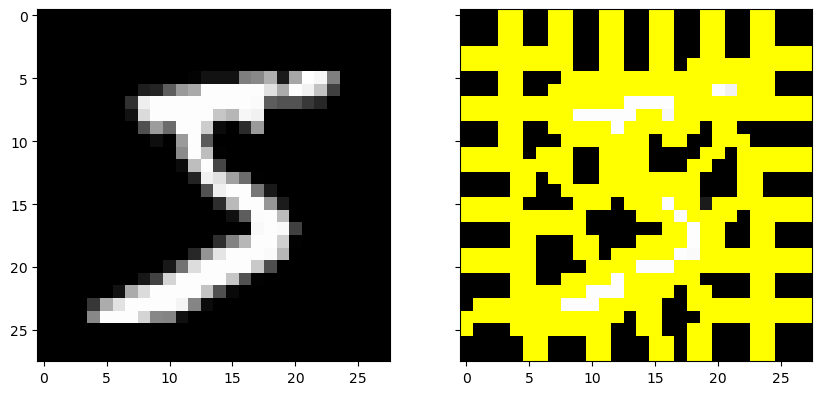

In [82]:
# Check that it works by ploting the image and its segmentation
processed_image = _preprocess(x_train[0,:,:])
segs = get_slic(x_train[0,:,:], n_segments=50, compactness=10)
fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0].imshow(processed_image)
ax[1].imshow(mark_boundaries(processed_image, segs))
plt.show()

It looks a bit weird because the size of the image is soo tiny. We can scale up the image to get a better look at the segmentation

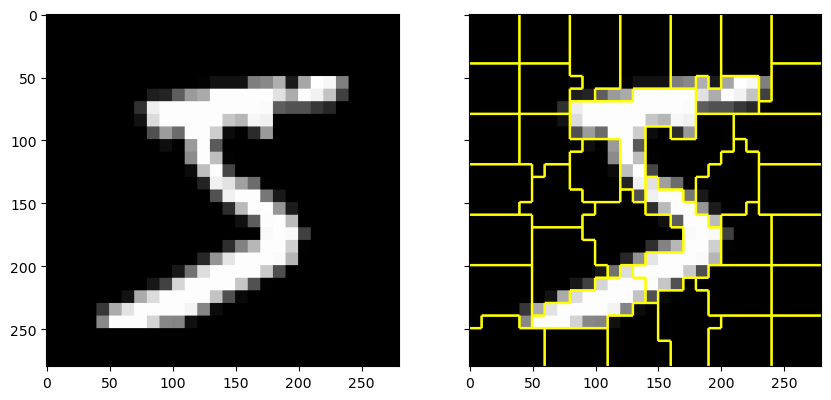

In [83]:
def scale_image(image, scale):
  image = np.repeat(image, scale, axis=0)
  image = np.repeat(image, scale, axis=1)
  return(image)

scale = 10 
scaled_im = scale_image(processed_image, scale)
scaled_seg = scale_image(segs,scale)

fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0].imshow(scaled_im)
ax[1].imshow(mark_boundaries(scaled_im, scaled_seg))
plt.show()

Next we want to convert these segments to graphical nodes. 

In [84]:
 # Compute the graph g from the segmentation using mean colors. This can be done using the function rag_mean_colour in graph
g = graph.rag_mean_color(processed_image, segs)

In [85]:
print('Nodes: \n', g.nodes) #print nodes
print('Degrees: \n', g.degree) #print number of degrees of each node (connections)
print('Edges: \n', g.edges) # print the connections
print('Node 0: \n', g.nodes) #print the properties of the nodes

Nodes: 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
Degrees: 
 [(1, 3), (2, 4), (3, 4), (4, 3), (5, 4), (6, 4), (7, 2), (8, 5), (9, 7), (10, 4), (11, 6), (12, 10), (13, 4), (14, 7), (15, 5), (16, 5), (17, 4), (18, 5), (19, 4), (20, 6), (21, 4), (22, 9), (23, 6), (24, 6), (25, 4), (26, 4), (27, 5), (28, 4), (29, 7), (30, 7), (31, 5), (32, 4), (33, 4), (34, 3), (35, 4), (36, 3), (37, 3)]
Edges: 
 [(1, 2), (1, 8), (1, 9), (2, 3), (2, 8), (2, 9), (3, 4), (3, 9), (3, 12), (4, 5), (4, 12), (5, 6), (5, 11), (5, 12), (6, 7), (6, 10), (6, 11), (7, 10), (8, 9), (8, 13), (8, 14), (9, 12), (9, 13), (9, 14), (10, 11), (10, 16), (11, 12), (11, 15), (11, 16), (12, 14), (12, 15), (12, 17), (12, 22), (12, 23), (13, 14), (13, 19), (14, 17), (14, 19), (14, 20), (15, 16), (15, 18), (15, 22), (16, 18), (16, 21), (17, 20), (17, 23), (18, 21), (18, 22), (18, 24), (19, 20), (19, 25), (20, 25), (20, 23), (20, 27), 

This is what you should get: 

Nodes:  
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]

Degrees:   
 [(0, 3), (1, 4), (2, 4), (3, 3), (4, 4), (5, 4), (6, 2), (7, 5), (8, 7), (9, 4), (10, 6), (11, 10), (12, 4), (13, 7), (14, 5), (15, 5), (16, 4), (17, 5), (18, 4), (19, 6), (20, 4), (21, 9), (22, 6), (23, 6), (24, 4), (25, 4), (26, 5), (27, 4), (28, 7), (29, 7), (30, 5), (31, 4), (32, 4), (33, 3), (34, 4), (35, 3), (36, 3)]

Edges:  
 [(0, 1), (0, 7), (0, 8), (1, 2), (1, 7), (1, 8), (2, 3), (2, 8), (2, 11), (3, 4), (3, 11), (4, 5), (4, 10), (4, 11), (5, 6), (5, 9), (5, 10), (6, 9), (7, 8), (7, 12), (7, 13), (8, 11), (8, 12), (8, 13), (9, 10), (9, 15), (10, 11), (10, 14), (10, 15), (11, 13), (11, 14), (11, 16), (11, 21), (11, 22), (12, 13), (12, 18), (13, 16), (13, 18), (13, 19), (14, 15), (14, 17), (14, 21), (15, 17), (15, 20), (16, 19), (16, 22), (17, 20), (17, 21), (17, 23), (18, 19), (18, 24), (19, 24), (19, 22), (19, 26), (20, 23), (20, 25), (21, 22), (21, 23), (21, 29), (21, 28), (21, 31), (21, 32), (22, 26), (22, 28), (23, 25), (23, 29), (23, 30), (24, 26), (24, 27), (25, 29), (25, 30), (26, 27), (26, 28), (27, 33), (27, 28), (28, 32), (28, 33), (28, 36), (29, 30), (29, 31), (29, 34), (29, 35), (30, 34), (30, 35), (31, 32), (31, 34), (32, 36), (33, 36), (34, 35)]

Node 0:  
 {'labels': [0], 'pixel count': 16, 'total color': array([0., 0., 0.]), 'mean color': array([0., 0., 0.])}

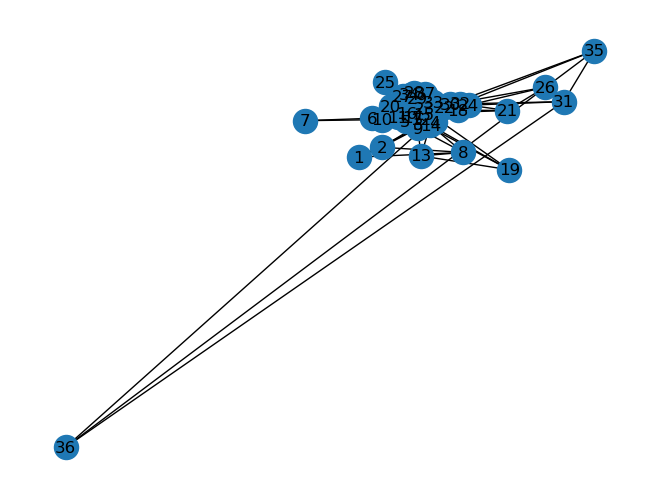

In [86]:
#draw the graph 
nx.draw(g, with_labels=True)
plt.draw()
plt.show()

shape:  (37, 37)


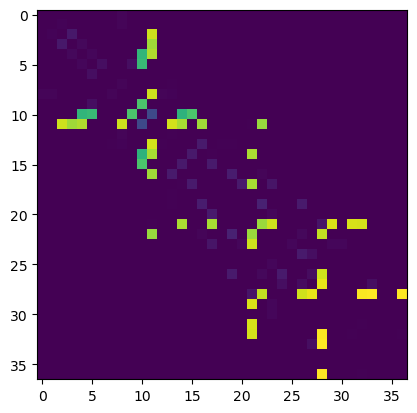

In [95]:
A = nx.adjacency_matrix(g).todense()  # get the adjacency matrix from the graph and convert to dense format
print('shape: ', np.shape(A))
plt.imshow(A, cmap='viridis')
plt.show()

# 3D objects
3D data is hard to come by. Here we use ModelNet 3D objects. To use them, we need to represent them as cloud point data and assume points are nodes in a graph. The cloud point data are obtained by sampling the surface of the 3D objects.

In [ ]:
import os
import glob
#.!pip install trimesh
import trimesh
#.!pip install git+https://github.com/tkipf/gcn.git
from __future__ import division
from __future__ import print_function
from sklearn.neighbors import NearestNeighbors
from gcn import *
from gcn.models import GCN, MLP

import time
import scipy.sparse as sp
from scipy.sparse import csr_matrix

ModuleNotFoundError: No module named 'gcn.models'

In [ ]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

In [ ]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

In [ ]:
# Convert mesh to point cloud we need to do sampling
points =  #sample 2000 points from the mesh using the sample function 

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [ ]:
# parse through folders of ModelNet to get dataset
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

We will sample 100 points from each 3D object in the dataset - because any larger will be too large to run! 

In [ ]:
npoints = 100 #number of points to sample
nclasses = 10  #number of classes/labels

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(npoints)

In [ ]:
print('train size:', train_points.shape) # we have 3991 sets of training data each with 1000 points with x,y,z location coordinates
print('test size:', test_points.shape) # we have 908 sets of test data each with 1000 points with x,y,z location coordinates

In [ ]:
i = 1500 #plot the 1500th training sample

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(train_points[i, :, 0], train_points[i, :, 1], train_points[i, :, 2])
ax.set_axis_off()
fig.suptitle('label: '+CLASS_MAP[train_labels[i]]) #title is the label
plt.show()

We need to make a graph from the point cloud data. This can be done with help from k-nearest neighbours agorithm to find points that live close together in space.

In [ ]:
# this function converts point cloud data into a graph
def pc2graph(pc, knn, threshold):
  G =  # initialise networkx graph
  N =  #number of nodes 
  ix = #make an array with the number of each node

  nn = NearestNeighbors(n_neighbors=knn, metric='euclidean',
                              leaf_size=15, n_jobs=-1).fit(pc)
  distances, indices = nn.kneighbors(pc) #returns the distances and indices of the k-nearest neihgbours for each node


  #make a list of pairs of nodes which are neighbours
  edges = # array of size [N,3] that stores the pair indices and the distances between them

  # add nodes to graph using any function from nx 

  # add edges, weighted by the distances between the pairs using any function from nx

  return G



Now let's check that function works, by getting a graph of the 1st 3D object and plotting it

In [ ]:
pc = train_points[0,:,:] # point cloud data
knn = 8 #number of neighbours
threshold = 20 # minimum distance of nodes to be a neighbour
G = pc2graph(pc, knn, threshold)

In [ ]:
nx.draw(G, with_labels=True) #This graph looks really messy because the huge number of nodes. It may be useful to look at the graph made with less points, this can by done by editing pc

In [ ]:
A = #get adjacency matrix
plt.imshow(A);

In [ ]:
# Get laplacian - remember the Laplacian = D - A or you can use a function from nx
L =
plt.imshow(L.toarray());

Now we train on the data. We have used just 100 points, any larger and you may want to reduce the number of nodes using pooling. 

In order to do classification we need to make an adjacency matrix from all the graphs. This is going to be huge - for 100 nodes and 100 training objects, that's a 10000x10000 matrix already!! So let's just use 100 training objects from 2 classes - toilet and bed, 50 from each

In [ ]:
CLASS_MAP #list the objects

The adjacency matrix is a matrix of all the individual graph adjacency matrices stacked along the diagonal.

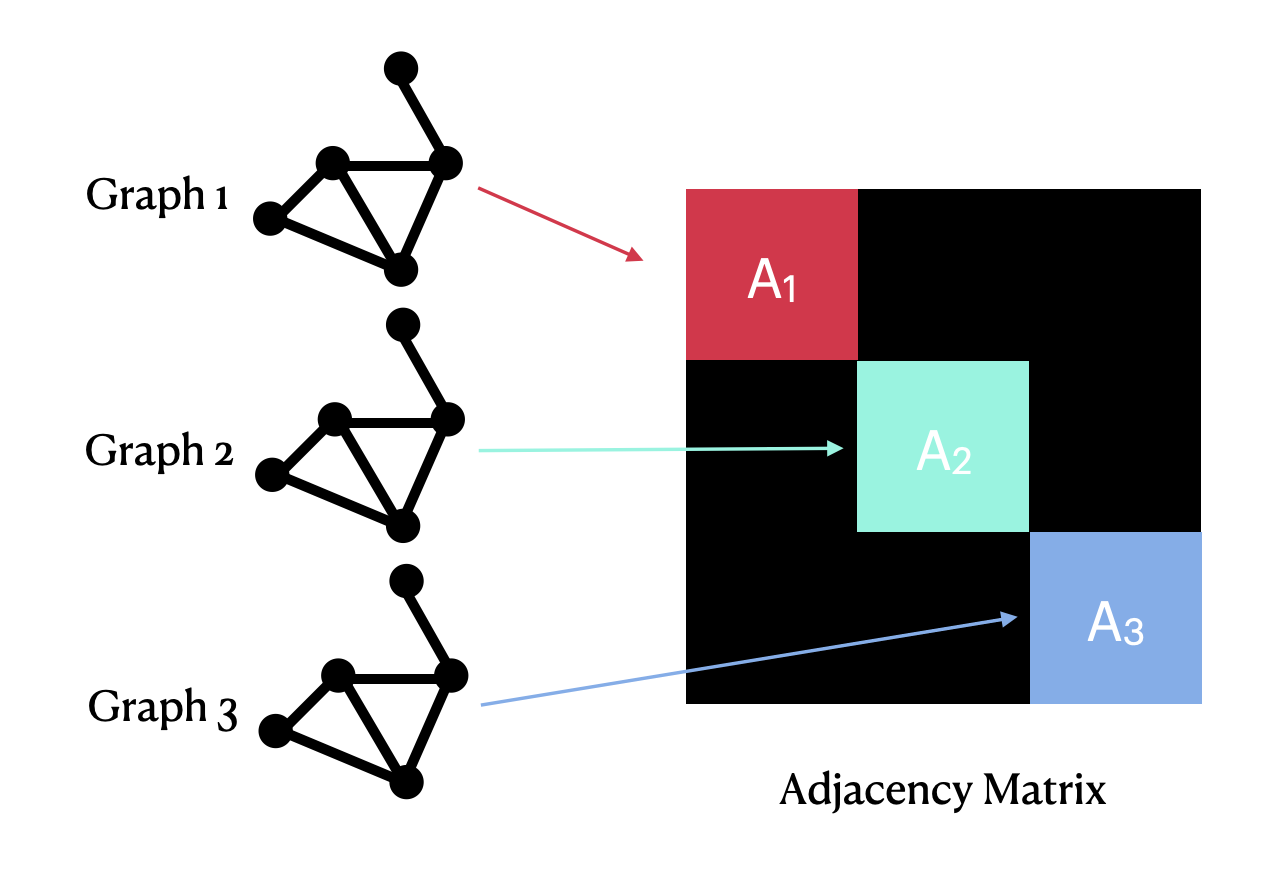



In [ ]:
#write a function that takes the classes that you are interested, the number of data samples from each class you want to use and the number of points in each object, and returns a combined adjacency matrix for the graphs in your dataset, and the corresponding labels.  

def make_adj(npoints, train_labels, ndata, classes, knn, threshold):  
  # npoints: number of nodes in each graph
  # train_labels: training labels from the graphs
  # ndata: number of data samples in each class
  # classes: array of classs indices

  nclasses = # number of classes
  adj_sz = # size of adjacency matrix
  A = np.zeros([adj_sz, adj_sz]) #make an empty matrix to store the values of the adjacency matrix
  
  labels = []
  ind = []
  for c in classes: #loop over the classes get the indices and labels of each class
    labels = np.append(labels, np.repeat(c, ndata))
    ind = np.append(ind, np.where(train_labels == c)[0][0:ndata])
  
  #shuffle the data, but make sure you shuffle both the indices labels simultaneously! 
  sortlabels = 
  sortind = 

  # Here you need to get the graph for each object in sortind, and append the adjacency matrix to the larger adjacency matrix of all the graphs

  return(A, sortlabels)


In [ ]:
# To check it works make and plot the adjacency matrix, it should only contain values along the diagonal. 
A, y = make_adj(npoints = npoints, train_labels=train_labels, ndata = 50, classes=[4,8], knn=8, threshold=20)
plt.imshow(A);

Now we will use the public code GCN to train our network. GCN requires an adjacency matrix in scipy compressed sparse row format, a feature matrix and the labels.

In [ ]:
adj = csr_matrix(A) #convert adjacency matrix to compressed sparse row format

In [ ]:
# make a N x f, feature matrix where N is number of nodes and f is number of features. We will use the identity matrix. The feature matrix needs to be in the scipy list of lists format
features = 
features = sp.lil_matrix(features) 

In [ ]:
# make a binary label matrix, this is length of the adjacency matrix x number of classes in size. It is a one hot encoded.
labels = 

We need to make masks for the training, validation and test sets, these are arrays with True/False values corresponding to the each row in labels telling you if the label is used in the training/validation/test sample. 

In [ ]:
# use first 80 for training, 10 for validation, 10 for test
train_mask = 
val_mask = 
test_mask = 
y_train = labels
y_val = labels
y_test = labels

In [ ]:
features = preprocess_features(features) # we need to preprocess the features and adjacency matrix, normalising them. 
support = [preprocess_adj(adj)]
num_supports = 1

The following is taken from GCN public code - https://github.com/tkipf/gc

In [ ]:
from gcn.layers import *
from gcn.metrics import *

class Model(object):
    def __init__(self, **kwargs):
        allowed_kwargs = {'name', 'logging'}
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        name = kwargs.get('name')
        if not name:
            name = self.__class__.__name__.lower()
        self.name = name

        logging = kwargs.get('logging', False)
        self.logging = logging

        self.vars = {}
        self.placeholders = {}

        self.layers = []
        self.activations = []

        self.inputs = None
        self.outputs = None

        self.loss = 0
        self.accuracy = 0
        self.optimizer = None
        self.opt_op = None

    def _build(self):
        raise NotImplementedError

    def build(self):
        """ Wrapper for _build() """
        with tf.variable_scope(self.name):
            self._build()

        # Build sequential layer model
        self.activations.append(self.inputs)
        for layer in self.layers:
            hidden = layer(self.activations[-1])
            self.activations.append(hidden)
        self.outputs = self.activations[-1]

        # Store model variables for easy access
        variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=self.name)
        self.vars = {var.name: var for var in variables}

        # Build metrics
        self._loss()
        self._accuracy()

        self.opt_op = self.optimizer.minimize(self.loss)

    def predict(self):
        pass

    def _loss(self):
        raise NotImplementedError

    def _accuracy(self):
        raise NotImplementedError

    def save(self, sess=None):
        if not sess:
            raise AttributeError("TensorFlow session not provided.")
        saver = tf.train.Saver(self.vars)
        save_path = saver.save(sess, "tmp/%s.ckpt" % self.name)
        print("Model saved in file: %s" % save_path)

    def load(self, sess=None):
        if not sess:
            raise AttributeError("TensorFlow session not provided.")
        saver = tf.train.Saver(self.vars)
        save_path = "tmp/%s.ckpt" % self.name
        saver.restore(sess, save_path)
        print("Model restored from file: %s" % save_path)


class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += 5e-4 * tf.nn.l2_loss(var)

        # Cross entropy error
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=16,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=16,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)


In [ ]:
# Define placeholders
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

# Create model
model = GCN(placeholders, input_dim=features[2][1], logging=True)

# Initialize session
sess = tf.Session()


# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)


# Init variables
sess.run(tf.global_variables_initializer())

cost_val = []

# Train model
for epoch in range(200):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)

    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    cost_val.append(cost)

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

print("Optimization Finished!")

# Testing
test_cost, test_acc, test_duration = evaluate(features, support, y_test, test_mask, placeholders)
print("Test set results:", "cost=", "{:.5f}".format(test_cost),
      "accuracy=", "{:.5f}".format(test_acc), "time=", "{:.5f}".format(test_duration))